I was experimenting with applying variational dropout, using multiplicative Gaussian output noising, to primal generalized Gaussian process models. I'm going to show an example of Gaussian process classification with dropout, and show that it gives nearly the same performance as early stopping with Adagrad. This is because of some surprising connections between Adagrad and dropout

In these models, we are trying to minimize the following quantity,

$\mathbb{E}_q\left[\sum_i L(\mathbf{\hat{y_i}},\mathbf{y_i})\right]$ (1),

where $\mathbf{\hat{y}} =(1 + \mathbf{A}) \mathbf{K \alpha}$ is the vector of observations of the dependent variable we are trying to predict (or a matrix for multi-output regression or classification). This gives multiplicative noise, rather than additive noise as with standard L2 regularization. Here, $\mathbf{K}$ is the kernel matrix, from some positive-definite kernel function defining a reproducing kernel Hilbert space (RKHS). $\mathbf{\alpha}$ are function space weights. By the representer theorem, the function $\hat{f}$ minimizing the above quantity can be written as a linear combination of the basis functions at each training point, where $\mathbf{\alpha}$ are the weights. The matrix $\mathbf{A}$ is diagonal whose entries are normally distributed with mean zero and some standard deviation $\sigma$.



[Kingma et al. 2015](https://arxiv.org/abs/1506.02557) showed that dropout with multiplicative weight noising is equivalent to doing variational inference with a log-uniform Jefferys prior. They also explored variational dropout, where the noise is placed on layer outputs instead of weights themselves. Weight noise only affects the objective function through the output anyway. Kingma et al. introduced a form of dropout with multiplicative output noising that exactly matches multiplicative weight noising in expectation, by taking into account correlations of output variables. Unlike Kigma et al., I'm ignoring these correlations. For single-output models, it's the same thing anyway, since there is only one output dimension anyway. The advantage of this is that we can think of it as noise on our dependent variable specifically. In the context of generalized Gaussian process regression, I this formulation is more natural.

As I mentioned, Jefferys priors are invariant to reparameterizations. This invariance explains why dropout works so well compared to L2 regularization for deep neural networks: You have no idea of the scale of the weights, since their effect on the objective function is only through one or more nonlinear transformations. An invariant prior makes no assumption of the *scale* of the weights, on the other hand. For linear regression, you can get the same invariance by just whitening your data ahead of time. However, this doesn't work for GLMs. Hence, dropout could still be useful.

 

## Stochastic variational inference

My main motivation trying this model is to test the effectiveness of multiplicative output noising for stochastic variational Bayes. Gaussian process regression with a Gaussian prior is a conjugate model. We can exactly, and tractably, get the posterior distribution. This doesn't hold for much else, though. Other error models, corresponding to log-loss, robust Student-t loss, etc., are usually not conjugate to a Gaussian prior, nevermind a Jefferys prior. With non-conjugate models, it is usually computationally infeasible to calculate the normalization constant because it involves a high-dimensional integral.

Stochastic variational inference handles this problem elegantly. To review, variational inference in general tries to approximate an intractable posterior distribution $P(z|x)$ with a simpler distribution $Q(z)$ from some restricted family. The idea is to fit $Q(z)$ (based on whatever variational parameters it has) such that it is as close to $P(z|x)$ as possible. "Closeness" is defined as KL divergence of $P(z|x)$ *from* $Q(z)$:

$\mathrm{D_{KL}}(Q||P) = \mathbb{E}_Q \left[ \log P(z|x) - \log Q(z)) + \log P(x) \right]$ 
(2)

Note that $\log P(x)$ (known as the log evidence) is fixed with respect to $z$. Removing this term gives *negative* of the evidence lower bound, or ELBO. We will denote this by $\mathcal{L}(Q)$. Maximizing the ELBO gives the optimal $Q(z)$. We can also decompose the posterior $\log P(z|x)$ into a prior term $F(z)$ and a likelihood term $H(z|x)$. We can then rewrite the ELBO as follows:

$\mathcal{L}(Q) = \mathbb{E}_Q \left[ \log H(z|x) + \log F(z) - \log Q(z) \right]$ (3),

or,

$\mathcal{L}(Q) = \mathbb{E}_Q \left[ \log H(z|x)\right] +  \mathrm{D_{KL}}(Q||F)$ (4),

Here, we can see that maximizing the ELBO tries make the expectation of the log-likelihood $\log H(z|x)$ big. But it also tries to keep $Q(z)$ close to the prior $F(z)$. 

For our case of generalized Gaussian process models with output noising, we have a log-uniform prior $F(\log(|y|)) \propto c$ on the output $y$. The likelihood is given by Eq. (1). We then optimize Eq. (4) over the implicit variational distribution $Q$ formed by the multiplicative Gaussian output noise.

For our model of multiplicative output noising, $Q$ has two parameters we can try to fit: We have the vector of coefficients $\alpha$, and we have the multiplicative noise standard deviation $\sigma$. The exact posterior has the parameter $\alpha$, but $\sigma$ is only a parameter of $Q$. Expected likelihood is given by Eq. (1).

The likelihood term is not analytically tractable. Here is where the magic of stochastic variational inference comes in. The expected likelihood $\mathbb{E}_Q \left[ \log H(z|x)\right]$ can be found by sampling from $Q(Z)$! In our case, this is done by just explicitly multiplicatively noising the output of or model. This is very easy. It allows you to turn a frequentist model into a variational Bayesian model in a few keystrokes. It sure beats MCMC. While we never get an analytical posterior distribution, we can easily sample from it.

This KL divergence $\mathrm{D_{KL}}(Q||F)$ does not have a tractable form either. It depends only on $\sigma$, not on the coefficients $\alpha$. If we fix the multiplicative noise level $\sigma$, this term can be ignored, since it is not affected by $\alpha$. It can be formed by sampling, but [Molchanov 2017](https://arxiv.org/abs/1701.05369) came up with a very accurate analytical approximation. Unfortunately, I got pretty inconsistent results allowing for $\sigma$ to adapt. Therefore, here I keep the noise level fixed, meaning that we can ignore the KL term and just fit the variational distribution based on expected log-likelihood, given by Eq. (1).

## Multiplicative output noising, L2 regularization, and early stopping

I used Adagrad gradient descent to train these models. I found that adding no regularization tended to produce results almost as good as using dropout, except with an order of magnitude less iterations. Even with very noisy datasets, I wasn't getting much in the way of overfitting, despite the fact that unregularized kernel models will exactly fit the data at the optimal solution. A big disadvantage of dropout is that it produces longer training times, since it adds variance to the model. When using it for a kernel method on datasets with not too complicated decision boundaries, you need a really big dropout rate to get any kind of effective regularization. That makes the variance problem worse.

To illustrate this, I'll fit the "circles" synthetic data from Scikit-Learn. This gives synthetic data for a binary classification problem where the points belonging to each class lie on two concentric circles. Here, I generate 1000 samples, with added noise, causing the circles to overlap. I fit three different models to these data: First, Gaussian process classification with no dropout or regularization, trained with Adagrad for 500 epochs. Second, a Gaussian process classification model with dropout trained with Adagrad to 5000 epochs. Third, Scikit-Learn's Gaussian process classification model with hyperparameter adaptation. 10,000 different points were generated as test data. The first two models were written using Tensorflow.

In [55]:
from variational_glm import *
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.datasets import make_circles
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
import scipy.linalg as la
import sklearn.gaussian_process as gp

#matplotlib as weird defaults.
plt.style.use('ggplot')
n_points=10**3
n_test = 10**4
gamma=100
np.random.seed(0)

#two models for gradient-descent trained GPR.
#Trying to keep to sklearn API, other parameters are in
#"fit" method.
mod_nodrop = LinearModel(logistic_loss)
mod = LinearModel(logistic_loss)

#generate train and test data
circles = make_circles(n_points,noise=0.1)
test_circles = make_circles(n_test, noise=0.1)

#get the kernel matrices for train and test data.
K = rbf_kernel(circles[0],circles[0],gamma=gamma) 
Y = circles[1][:,np.newaxis]
K_test = rbf_kernel(test_circles[0],circles[0],gamma=gamma)
Y_test = test_circles[1]

mod_nodrop.fit(K,Y,learning_rate=1e-6,n_epochs=500,batch_size=50,\
               init_stddev=1e-6,use_dropout=False,l2_penalty=0.)
mod.fit(K,Y,learning_rate=1e-6,n_epochs=5000,batch_size=50,\
        init_stddev=1e-6,use_dropout=True,l2_penalty=0.,dropout_stddev=1e0)

<variational_glm.LinearModel instance at 0x7f33c36156c8>

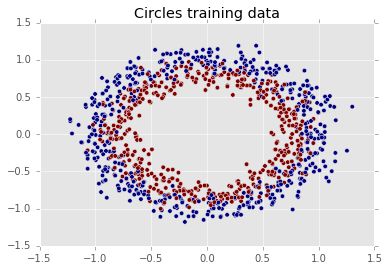

Accuracy with dropout: 0.8358
Accuracy without dropout: 0.8337
Accuracy of sklearn GPC: 0.8418


In [56]:
#plot the circles test data.
plt.scatter(circles[0][:,0],circles[0][:,1],c=Y,edgecolors=None)                                                                                                                                                               
plt.title("Circles training data")
plt.show()
#predictions with dropout
tf_preds = mod.predict(K_test)[:,0]
#predictions without dropout
tf_preds_nodrop = mod_nodrop.predict(K_test)[:,0]

corrects = ((tf_preds >0) == test_circles[1])
corrects_nodrop = ((tf_preds_nodrop >0)== test_circles[1])



#kernel is squared exponential and white noise kernel (L2 regularization)
kern = gp.kernels.RBF(length_scale=gamma)+gp.kernels.WhiteKernel()
g = gp.GaussianProcessClassifier(kernel=kern,n_restarts_optimizer=2)
g.fit(circles[0],circles[1])
preds_gpr = g.predict(test_circles[0])

print "Accuracy with dropout:", np.mean(corrects)
print "Accuracy without dropout:", corrects_nodrop.mean()
print "Accuracy of sklearn GPC:", (test_circles[1]==preds_gpr).mean()

From this, we can see that dropout with 5000 epochs gives only slightly superior performance to no dropout with almost no regularization, and only 500 epochs. The result without regularization does not overfit. Running it for 5000 iterations begins to degrade the performance, causing some overfitting, but not much. Keep in mind that the optimum solution for this kernel would *exactly fit* every training point, which would be enormously overfitting this dataset.


The fact that this model is not overfitting, despite being such a noisy dataset, must be due to the learning algorithm rather than the objective function. In most circumstances, kernel matrices are positive definite (i.e., they are nonsingular, with all positive eigenvalues). However, without regularization, they are usually numerically singular or close to it. This is because **the eigenvalues of kernel matrices usually decay exponentially**. There's a few big eigenvalues, but a lot of really small ones. This causes the problem to become ill-posed, and the parts of the solution corresponding to small eigenvalues converge slowly.

Kernel approximation methods like Nystroem or Random Kitchen Sinks exploit this fact in creating low-rank kernel matrix approximations. You can usually approximate the biggest, most important eigenvalues with a low-rank approximation quite well.

Sadly, the Sklearn gaussian process classification model beats dropout. It does optimize hyperparameters, which can help. However, I think the big difference is that even using Adagrad, it is too difficult to fit the parts of the objective corresponding to small eigenvalues. Sklearn uses second-order accurate L-BGFS, which can deal with this a lot better.

We can take an eigendecomposition of $\mathbf{K}$ to look at its spectrum. Below, I plot the log10 of the spectrum.

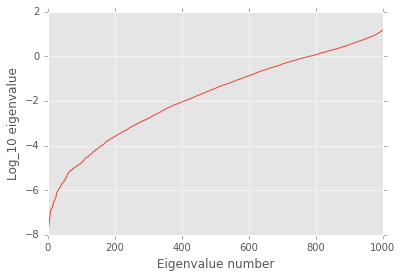

Log_10 condition number: 10.6476310408


In [57]:
#Put in a tiny diagonal component (like a tiny amount of L2 regularization) 
#so the eigenvalue decomposition is numerically stable.
K_eigs = np.sort(la.eigvals(K + 1e-8*np.eye(n_points)))
plt.plot(np.log10(K_eigs))
plt.xlabel("Eigenvalue number")
plt.ylabel("Log_10 eigenvalue")
plt.show()

print "Log_10 condition number:", np.log10(np.linalg.cond(K))

In this plot, eigenvalue 1000 is the largest, and 0 the smallest. Except for the smallest log eigenvalues, this is nearly linear. This confirms that the eigenvalues drop off exponentially. This also reveals an additional reason that kernel methods are almost invariably used with regularization: this exponential decay makes for very high condition numbers, about $10^{11}$ in this case. Direct linear solvers like Cholesky decomposition lose a ton of accuracy, and iterative methods like conjugate gradient simply won't work (at least without a really goodu preconditioner). Adding L2 regularization is equivalent to adding a diagonal matrix to $K$, which embiggens the very small eigenvalues, and can improve the condition number dramatically.

## $\mathbf{K}$, its eigenvalues, and its condition number

Let's examine the kernel matrix $\mathbf{K}$ some more. Remember that $K_{ij} = g(\mathbf{x}_i, \mathbf{x}_j)$, for data points $\mathbf{x}_i$ and $\mathbf{x}_j$, and a kernel function $g$ (we are using the squared-exponential kernel $g=\exp(-\gamma ||\mathbf{x}_i-\mathbf{x}_j||^2)$ here). For Gaussian processes, the kernel function gives the covariance between any two points, and $\mathbf{K}$ is the covariance matrix for a finite set of points $\mathbf{x}_1,...\mathbf{x}_n$.

For unregularized kernel regression with squared loss (I'm keeping it simple here), with data vector $\mathbf{y}$ and weights $\mathbf{w}$, we need to solve the system,

$\mathbf{K w} = \mathbf{y}$. 

Since $\mathbf{K}$ is positive definite (or at least positive semi-definite), we can do this eigenvalue decomposition:

$\mathbf{K} = \mathbf{Q \Lambda Q^T},$

where $\mathbf{Q}$ are the orthogonal eigenvectors and $\mathbf{\Lambda}$ is a diagonal matrix formed by the eigenvalues. We can multiply both sides on the left by $\mathbf{Q^T}$ to yield the system,

$\mathbf{\Lambda Q^T w} = \mathbf{Q^T y}$

or,

$\mathbf{\Lambda w^*} = \mathbf{w^*},$

where $\mathbf{w^*}$ and $\mathbf{y^*}$ are respectively $\mathbf{w}$ and $\mathbf{y}$ transformed by $\mathbf{Q^T}$. Since $\mathbf{\Lambda}$ is diagonal, the solution for an arbitrary weight $w_i$ is,

$w_i  = \frac{y_i^*}{\lambda_i}$

If $\lambda_i$ is really small, then $w_i^*$ is really sensitive to measurement noise in $y_i^*$. Also, because floating point numbers aren't actually numbers, it becomes increasingly numerically unstable. So, it's necessary to do some kind of modification to the kernel matrix to ease this problem. An obvious fix is the standard L2 regularization: Add a diagonal matrix $\mathbf{\Xi}$ to $\mathbf{K}$. Then we are trying to solve the system,

$(\mathbf{K} + \mathbf{\Xi})\mathbf{w} = \mathbf{y}$

If we diagonalize this just like before, we wind up with,

$\mathbf{(\Lambda + \Xi) w^*} = \mathbf{Q^T y^*}$

Note that now, an eigenvalue of this system $\lambda_i + \xi_i$, where $\xi_i$ is the $i$ diagonal component of $\Xi$. This bounds the eigenvalue from below by $\xi_i$. The solution for $w^*_i$ is,

$w_i^* = \frac{y_i^*}{\lambda_i + \xi_i}$

So, we can see here that weights associated with small eigenvalues ($\lambda_i \ll \xi_i$) approach $y_i^*/\xi_i$, so weights can't get too massive. Weights associated with small eigenvalues are damped a lot, weights associated with big eigenvalues aren't damped as much (i.e., they are more faithful to the data).

Instead of thinking of this problem as solving a linear system, we can view it as an equivalent minimization problem. Again, in reference frame where the kernel matrix is diagonal, we can just write this as a bunch of independent scalar problems for simplicity:

$\min_{w^*_i}((\lambda_i + \xi_i)w^*_i - y^{*T}_i)^2$

The corresponding solution for a weight $w_i^*$ of the unregularized problem (with $\xi_i = 0$) is $y^*_i/\lambda_i$.

## Dropout as multiplicative noise, and as additive noise

Dropout is one of the most popular regularization techniques for neural networks. In the standard Bernoulli dropout, each neuron is turned of with some probability at each iteration. Another version instead adds *multiplicative* Gaussian noise to inputs of a layer. These two variants are pretty much the same, because repeated trials of the Bernoulli distribution (i.e. the binomial distribution) approach the normal distribution due to the central limit theorem. Since this noise only affects the objective function through the activation functions, we can instead add noise to the preactivations. In a linear model, this corresponds to multiplicative output noise (i.e. noise on $\mathbf{\hat{y}}$) instead of noise in the weights or the input dimensions. The output dimension is usually quite a bit smaller than the input, so this version is computationally easier. It's also feasible to generate a sample for each example in every minibatch, which helps reduce variance of the gradient. Noising the inputs, or noising the outputs of a generalized Gaussian process model is a six-of-one, half a dozen of the other sort of situation.

Note that with the assumption of a squared-exponential kernel (or any kernel continuous at $\mathbf{x}_i = \mathbf{x_j}$), we are assuming there is no measurement noise in $y^*_i$. Measurement noise is usually thought of as something similar to Gaussian white noise. The noise of an individual observation shouldn't be correlated with a spatially nearby observation. However, if the kernel is continous, then for any $\epsilon >0$, we can choose $\delta$ such that if $||\mathbf{x}_i - \mathbf{x}_j|| < \delta$, then 

$\mathrm{Corr}(\mathbf{x}_i, \mathbf{x}_j) = \frac{\mathrm{Cov}(\mathbf{x}_i, \mathbf{x}_j)}{\sqrt{\mathrm{Cov}(\mathbf{x}_i, \mathbf{x}_i) \mathrm{Cov}(\mathbf{x}_j, \mathbf{x}_j)}} = \frac{\mathbf{K_{ij}}}{\sqrt{\mathbf{K}_{ii} \mathbf{K}_{jj}}} > 1 - \epsilon$

With these kind of kernels, if we have a realization of the Gaussian process at a particular point, then we know the value at sufficiently nearby points almost perfectly. Therefore, another way of arriving at L2 regularization, like in the previous section, is to add a white noise kernel to the squared-exponential kernel. The standard white noise kernel is defined as $\kappa(\mathbf{x}_i,\mathbf{x}_j) = \zeta$ if $\mathbf{x}_i = \mathbf{x}_{j}$, and $\kappa(\mathbf{x}_i,\mathbf{x}_j)=0$ otherwise. It's possible to make $\zeta$ spatially dependent, and give it a prior, etc. 

Note that with Gaussian process models, by using the representer theorem the noise is viewed as being on $\mathbf{y}$, rather than on the weights as with Bayesian linear regression. I think this also makes way more intuitive sense. Who cares what noise on the weights is, or what the weights even are? We only care about the predictions $\mathbf{\hat{y}}$.

From before, remember that we are trying to minimize this objective:

$\mathbb{E}_q[ L(\mathbf{\hat{y}},\mathbf{y})]$,

where $L$ is some loss function. Let's focus on ordinary regression, with squared loss. In this case, it is well-known that ordinary Bayesian linear regression with Gaussian priors scaled by the standard deviation of each feature is the same as using dropout. It's the same with Gaussian process regression, since Gaussian process regression is identical to weight-space linear regression. But, let's look at it in terms of output noise instead of weight noise. So, in this case, we are trying to minimize

$\mathbb{E}_q[ \frac{1}{2}||\mathbf{y} - \mathbf{\hat{y}}||^2] = \mathbb{E}_q[ ||\mathbf{y} - (1+A)\mathbf{K \alpha}||^2]$

We can rewrite this as follows:

$\mathbb{E}_q[ \frac{1}{2}(\mathbf{y} - \mathbf{K \alpha} + \mathbf{A} \mathbf{K \alpha})^2]$.

The last term involving the diagonal normal matrix $\mathbf{A}$ is the only stochastic term. Now, if we expand this out, noting that $A$ has a mean of zero and its distribution is symmetric about the mean, we have,

$\mathbb{E}_q[ \frac{1}{2}||\mathbf{y} - \mathbf{K \alpha} + \mathbf{A} \mathbf{K \alpha}||^2] = ||\mathbf{y} - \mathbf{K \alpha}||^2 + \mathbb{E}_q(||\mathbf{A} \mathbf{K \alpha}||^2)$.

Now, the expectation in the second term reduces to $\sigma^2 ||\mathbf{K} \alpha||$. That means we are trying to minimize this:

$\mathbb{E}_q[ \frac{1}{2}||\mathbf{y} - \mathbf{K \alpha} + \mathbf{A} \mathbf{K \alpha}||^2] = \frac{1}{2}||\mathbf{y} - \mathbf{K \alpha}||^2 + \frac{1}{2}\sigma^2 ||\mathbf{K} \alpha||^2$.

This looks a lot like ordinary ridge regression/Gaussian process regression. Differentiating this, and setting the gradient to zero yields this system:

$(\mathbf{K} + \sigma^2 \mathbf{K})\mathbf{\alpha} = \mathbf{y}$

The solution is,

$\alpha = \frac{1}{1+\sigma^2}\mathbf{K}^{-1}\mathbf{y}$

This just means that all of the weights are shrunk by a factor of $1/(1+\sigma^2)$ compared to the unregularized solution. This is exactly the same thing as shrinkage in gradient boosting, which itself is usually thought of as a learning rate when viewing gradient boosting as gradient descent in function space.

Now, if we diagonalize just like before, the eigenvalues are also expanded by the same factor (corresponding to the same weight shrinkage as in the original reference frame). This means that dropout with output noising does absolutely nothing to improve conditioning of our problem. The condition number of the matrix, which is equal to the ratio of the largest to smallest eigenvalue, is unchanged. It does regularize the solution, in the more statistical sense of the word, in that it is robust to noise. But that is only a half of the reason why regularization is usually applied to kernel methods.

From before, here is the solution for a $\alpha^*_i$ in the diagonalized system with regular L2-regularized regression.

$\alpha^*_i = \frac{y^*_i}{\lambda_i + \xi_i}$

Now, the corresponding solution for the case of multiplicative output noising is,

$\alpha^*_i = \frac{y^*_i}{\lambda_i}\frac{1}{1+\sigma^2} = \frac{y^*_i}{\lambda_i + \lambda_i \sigma_i^2}.$

So, in this reference frame, multiplicative output noising is the same as L2 regularization, but scaled by the corresponding eigenvalue. This is of course the same result as the original reference frame. However, it allows us to make an easy comparison between early stopping and multiplicative output noising. Suppose we are trying to fit $\alpha_i^*$ (in the diagonal reference frame) in unregularized Gaussian process regression (with squared-error loss) by gradient descent with a constant learning rate. If we take the learning rate to be very small and the iterations large, we can treat it as an ODE for gradient flow, which is easier. We'll take the learning rate as $\eta$. For squared error loss, we have the following equation,

$\dot{\alpha}_i^* =   \eta(y^\star_i - \lambda \alpha_i^*)$

The solution to this with $\alpha^*_i(0)=0$ is,

$\alpha^*_i(t) = \frac{y^*_i}{\lambda_i}(1 - \exp(-\eta \lambda_i t))$ (10).

The solution as $t$ approaches infinity is the same as the unregularized problem. Also, the speed of convergence of depends exponentially on $\lambda_i$. This means that the solution for small eigenvalues converges exponentially more slowly than the big ones. When you also think that the spectrum of $\mathbf{K}$ decays exponentially, it's easy to see why plain-Jane gradient descent will never fit the components associated with the small eigenvalues in any reasonable number of iterations. This is the reason why I am using Adagrad for this model, which partially ameriolates this problem by using per-parameter adaptive learning rates. More on this in a bit.

From the previous equation, early stopping at time $t$ reduces $\alpha^*_i(t)$ by a factor of $(1 - \exp(\eta \lambda_i t)$! This is exactly the same thing as using multiplicative output noise with $\sigma$ chosen such that,

$(1 - \exp(\eta \lambda_i t)) = \frac{1}{1 + \sigma^2}$

Of course, as I said before, it's impossible to choose the proper learning rate $\eta$ without knowing the exact solution already. However, if we know the eigenvalues, we can think about what a good learning rate might look like. Suppose that for an eigenvalue of unity, with a learning rate of unity, we converge to our early-stopping point,

$\frac{y}{1}\frac{1}{1 + \sigma^2}$,

after a time of unity. Then suppose that instead of an eigenvalue of unity, we have $\lambda_i$ as before, which can be arbitrary. We also want to have,

$1 - \exp(\eta_i \lambda_i t) = \frac{1}{1 + \sigma^2}$,

after a time of $t=1$. Then we can simply solve for the learning rate $\eta_i$, yielding,

$\eta_i = \frac{\log(1 - \frac{1}{1+\sigma^2})}{\lambda_i}$

Thus, the learning rate should be inversely proportional to the eigenvalue. This is also what Newton's method does. Of course, in real life, we would not have $\mathbf{K}$ diagonalized. However, [Wager et al. 2013](https://arxiv.org/abs/1307.1493) showed dropout for GLMs is first-order equivalent to gradient descent with the learning rate scaled by the inverse diagonal of the Hessian, which is an approximation to Newton's method (or the natural gradient). In gradient descent element $h_i$ of the Hessian's diagonal can be estimated by,

$h_i \approx \frac{1}{\sum_i^n g^j_i g^j_i}$,

where $g_i^j$ is the gradient of of weight $i$, at iteration $j$. Adagrad is not so far off from this. With Adagrad, the learning rate is inversely proportional to the square root of sum of gradients at each step before that point. This means that components with small gradients (here, small eigenvalues) have their learning rates reduced less than components with big gradients (here, big eigenvalues).

This explains why early stopping with Adagrad seemed to be working surprisingly well for me.

In contrast, early stopping is completely outmoded for DNNs, and it makes sense why: With nice convex problems where you are basically walking to the bottom of a bowl, early stopping with Adagrad appears to be a decent regularizer: If you start from weights near zero, you walk down the bowl, with the length of your stride in each direction scaled by the curvature. If your bowl is more like a canoe, using Adagrad is basically like squashing the long axis to be closer to the short axis.

This analogy doesn't work for DNNs. They have a ton of minima, and a complicated landscape. It's not like walking down a bowl, but more like walking down a twisty canyon. The distance you have travelled doesn't bear much relation to how close you are to the optimum. Hence why early stopping doesn't work well.

# Conclusions

- Dropout is a bit disappointing for kernel models. The stochasticity introduced slows down training a lot, on top of having to use gradient descent instead of faster second-order methods. It also doesn't help ill-conditioning of the kernel matrix.

- However, dropout is an easy way to get Bayesian gaussian process GLMs using stochastic variational inference (not that stochastic additive noise couldn't be used as well). It ought to yield significantly more accurate posterior distributions than the Laplace approximation used by Scikit-learn. However, other methods like expectation propagation should be superior in every way.

- For squared-error loss, multiplicative output noise is the same as just multiplying the original kernel matrix by factor, or multiplicatively shrinking the weights by a predetermined amount.

- For generalized Gaussian process regression, it is hard to overfit with gradient descent, since it takes forever to fit the parts of the objective corresponding to small eigenvalues (when linearizing at each iteration). Neural networks tend to have much fewer parameters than the data size, unlike Gaussian processes, which helps ameriolate this problem.

- Early stopping with Adagrad with no regularization works surprisingly well. It's not as good as standard methods of regularization optimized with second-order methods, but its pretty interesting nonetheless.